<a href="https://colab.research.google.com/github/Shaurya-S0603/Stock-Market-Analyzer/blob/main/STOCK_MARKET_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CREATING THE BOT AND TRAINING IT**

**Importing Required Packages.**

In [1]:
!pip install ta yfinance xgboost lightgbm catboost --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from ta import add_all_ta_features
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.7 MB/s eta 0:00:00


**Getting the training dataset and exploring it**

In [14]:
# Replace 'stock_symbol' with the stock symbol you want to analyze
stock_symbol = 'GOOG'
start_date = '2021-01-01'
end_date = pd.Timestamp.now() + pd.DateOffset(days=30)

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
# Drop the second level of the MultiIndex if it exists
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.droplevel(1)
stock_data = stock_data.interpolate(method='time').bfill().ffill().copy()

/tmp/ipython-input-2381255164.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


**Feature Engineering**

In [15]:
def engineer_features(df):
    data = df.copy()
    # Reset index to handle potential MultiIndex issues with ta library
    original_index = data.index
    data = data.reset_index()

    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        if col in data.columns:
            # Ensure the column is 1-dimensional
            if isinstance(data[col], pd.DataFrame):
                data[col] = data[col].iloc[:, 0]
            else:
                data[col] = data[col].squeeze()

    print("Data before add_all_ta_features:")
    print(data[['Open', 'High', 'Low', 'Close', 'Volume']].head())
    print(data[['Open', 'High', 'Low', 'Close', 'Volume']].shape)

    data = add_all_ta_features(
        data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
    )

    # Set the index back to the original index
    data = data.set_index(original_index)

    for lag in range(1, 6):
        data[f'Close_Lag_{lag}'] = data['Close'].shift(lag)
    data['Volatility_21'] = data['Close'].rolling(window=21).std()
    data.dropna(inplace=True)
    return data

engineered_data = engineer_features(stock_data)

Data before add_all_ta_features:
Price       Open       High        Low      Close    Volume
0      87.279723  87.434169  84.812113  85.824684  38038000
1      85.663774  86.789569  85.316897  86.454361  22906000
2      84.552878  86.805960  84.372608  86.174782  52042000
3      86.411659  88.812231  86.262185  88.755127  45300000
4      88.791378  89.876944  88.074036  89.746338  41012000
(1178, 5)


**Implementing the SMA (Simple Moving Avg) Stratergy**


In [16]:
def SMA_strategy(data, short_window=20, long_window=50):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1).mean()
    signals.loc[signals.index[short_window:], 'signal'] = np.where(
        signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:], 1.0, 0.0
    )
    signals['positions'] = signals['signal'].diff()
    return signals

signals = SMA_strategy(engineered_data)

**Visualizing the statergy**

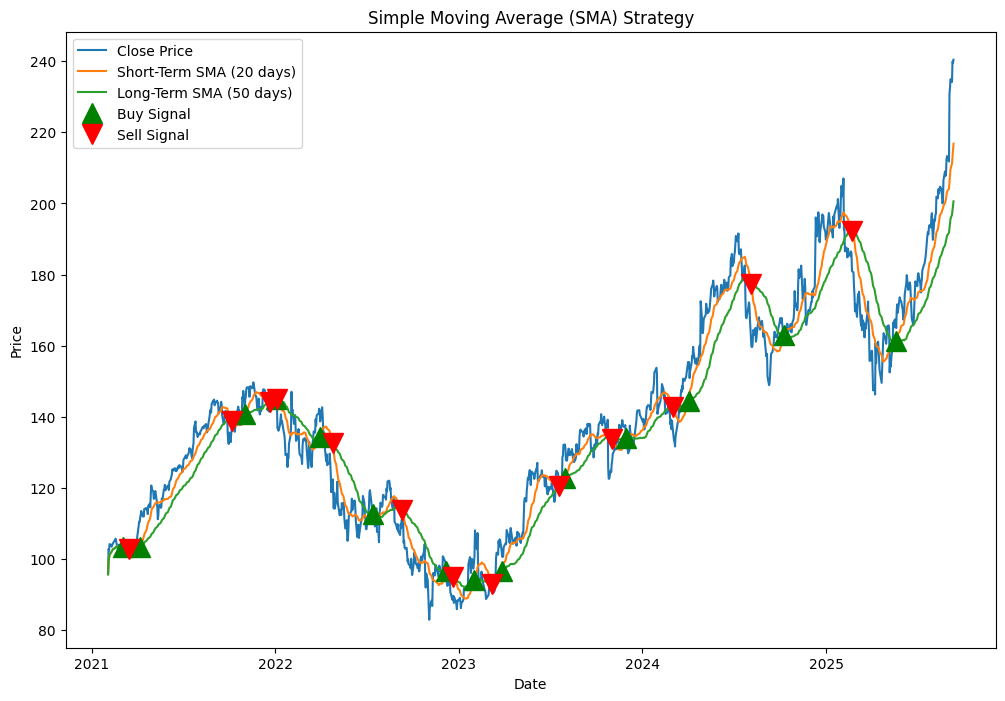

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(engineered_data['Close'], label='Close Price')
plt.plot(signals['short_mavg'], label='Short-Term SMA (20 days)')
plt.plot(signals['long_mavg'], label='Long-Term SMA (50 days)')
plt.plot(signals[signals['positions'] == 1.0].index,
         signals['short_mavg'][signals['positions'] == 1.0],
         '^', markersize=15, color='g', lw=0, label='Buy Signal')
plt.plot(signals[signals['positions'] == -1.0].index,
         signals['short_mavg'][signals['positions'] == -1.0],
         'v', markersize=15, color='r', lw=0, label='Sell Signal')
plt.title('Simple Moving Average (SMA) Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# **IMPLEMENTATION**

**Backtesting and Performance Evaluation**



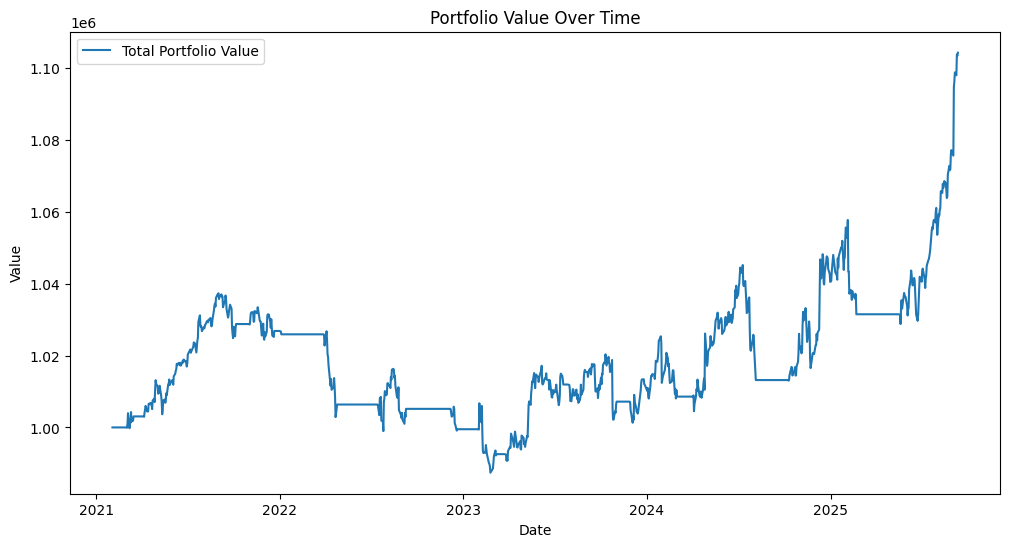

In [18]:
def backtest_strategy(data, signals, symbol='GOOG', trading_cost=0.001):
    initial_capital = 1_000_000
    price_column = 'Adj Close' if 'Adj Close' in data.columns else 'Close'
    positions = pd.DataFrame(index=data.index)
    positions[symbol] = 1000 * signals['signal']
    pos_diff = positions.diff().fillna(0.0)
    prices = data.loc[positions.index, price_column]
    trade_costs = (np.abs(pos_diff[symbol]) * prices * trading_cost).fillna(0)
    portfolio = pd.DataFrame(index=positions.index)
    portfolio['holdings'] = positions[symbol] * prices
    portfolio['cash'] = initial_capital - (pos_diff[symbol] * prices + trade_costs).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change().fillna(0.0)
    return portfolio

portfolio = backtest_strategy(engineered_data, signals, stock_symbol)

plt.figure(figsize=(12, 6))
plt.plot(portfolio['total'], label='Total Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

**RESULTS DISPLAY**

In [20]:
total_returns = (portfolio['total'].iloc[-1] - portfolio['total'].iloc[0]) / portfolio['total'].iloc[0] * 100
sharpe_ratio = portfolio['returns'].mean() / (portfolio['returns'].std() + 1e-9) * np.sqrt(252)
max_drawdown = ((portfolio['total'].cummax() - portfolio['total']) / portfolio['total'].cummax()).max() * 100
print(f"\nTotal Returns: {total_returns:.2f}%")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Max Drawdown: {max_drawdown:.2f}%")


Total Returns: 10.42%
Annualized Sharpe Ratio: 0.68
Max Drawdown: 4.81%


# **PREDICTION**

In [ ]:
X = engineered_data.drop(columns=['Close', 'Date'])
y = engineered_data['Close']

tscv = TimeSeriesSplit(n_splits=5)
xgb_params = {'n_estimators': [200, 500], 'learning_rate': [0.01, 0.05]}
model = XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(model, param_grid=xgb_params, cv=tscv, scoring='neg_mean_squared_error')
grid.fit(X, y)
best_model = grid.best_estimator_

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

future_dates = pd.bdate_range(start=engineered_data.index[-1] + pd.Timedelta(days=1), periods=10)
future_features = pd.DataFrame(index=future_dates)
last_row = X.iloc[-1]
for col in X.columns:
    future_features[col] = last_row[col]

future_preds = best_model.predict(future_features)
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_preds}).set_index('Date')

plt.figure(figsize=(12, 6))
plt.plot(engineered_data.index, engineered_data['Close'], label="Actual Close Price", color="blue")
plt.plot(future_df.index, future_df['Predicted_Close'], label="Predicted Close Price", color="red", linestyle="dashed")
plt.title(f"{stock_symbol} Close Price and 10-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
print(future_df)